# Global Warming: True or Faux?

Over the years, the world experiences global warming with varying temperatures and weather conditions. Depending on the environment, global warming can be either intense or mild in each country. In this research, we will find if there is a trend of global temperature increase across all countries through the years. 

Data Dictionary

|Variable |	Definition	| Dtype |
|---------|---------------------|-------|
|Region	|Location of Region |	Object
Country	| Location of Country | 	Object
State	| Location of State	|float64
City	| Major Cities	| Object
Month	| Month as Integer |	Object
Day	| Day as Integer	| int64
Year	| Year as integer	| int64
AvgTemperature|	Temperature in Fahrenheit |	int64


## Importing necessary libraries such as `pandas`, `matplotlib`, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import datetime
from datetime import date, timedelta
import requests
import urllib.request
from bs4 import BeautifulSoup
from scipy.stats import zscore
from scipy import stats

from scipy.stats import f_oneway
from sklearn.neighbors import DistanceMetric as dist
#from math import radians as rd
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

pd.set_option('mode.chained_assignment', None)

# Data - Daily Temperature of Major Cities Across the World


[Kaggle](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities) provides the data of the Average Temperature across Major Cities all over the World

In [2]:
df = pd.read_csv('./city_temperature.csv', low_memory=False)

# Data Types and Nulls

The number of columns with proper data types in the Average Temperature dataset

In [3]:
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Region          2906327 non-null  object 
 1   Country         2906327 non-null  object 
 2   State           1455337 non-null  object 
 3   City            2906327 non-null  object 
 4   Month           2906327 non-null  int64  
 5   Day             2906327 non-null  int64  
 6   Year            2906327 non-null  int64  
 7   AvgTemperature  2906327 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


# Dropping 'State' Column

The 'State' column is removed from the dataframe since (1)it has no significance in the study (2) uniformity since not all cities have states  

In [4]:
df = df.drop(['State'], axis = 1)

# Dropping Rows with Invalid Day Values

Identified rows with a value of "0" in the 'Day' column is removed from the dataframe since it is invalid value

In [5]:
df = df[df['Day'] != 0]
df

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...
2906322,North America,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,San Juan Puerto Rico,7,30,2013,83.8


# Retaining only the Rows with - the Timeframe (1995-01-01 - 2020-01-01)

The size of the dataset is reduced to only consider countries with data from January 01, 1995(minimum) to December 31, 2019(maximum) totalling to a time series analysis that stretches over 25 years. This is done to have a consistent comparison since not all countries the same recorded start and end date.

In [6]:
#getting city rows with starting year value less than 1995
df.groupby(['City'])['Year'].min().sort_values(ascending=True).head(10)
cone = df.groupby(['City'])['Year'].min().sort_values(ascending=True).head(8).reset_index()
cone = cone['City']
cone = cone.tolist()

#getting city rows with starting year value more than than 1995
df.groupby(['City'])['Year'].min().sort_values(ascending=True).tail(5)
ctwo = df.groupby(['City'])['Year'].min().sort_values(ascending=True).tail(2).reset_index()
ctwo = ctwo['City']
ctwo = ctwo.tolist()
ctwo

#getting city rows with maximum year value less than 2020
df.groupby(['City'])['Year'].max().sort_values(ascending=True).head(40)
cthree = df.groupby(['City'])['Year'].max().sort_values(ascending=True).head(37).reset_index()
cthree = cthree['City']
cthree = cthree.tolist()

#df.groupby(['City'])['Year'].max().sort_values(ascending=True).tail(10)

missing_cities = []
missing_cities = cone + ctwo + cthree
missing_cities = list(dict.fromkeys(missing_cities))
print(missing_cities)
print(len(missing_cities))

df = df[~df['City'].isin(missing_cities)]


['Hamburg', 'Oslo', 'Munich', 'Guadalajara', 'Maputo', 'Dar Es Salaam', 'Nairobi', 'Addis Ababa', 'Bishkek', 'Lagos', 'Yerevan', 'Bonn', 'Pristina', 'Flagstaff', 'Yuma', 'Frankfurt', 'Tbilisi', 'Bujumbura', 'Tel Aviv', 'Daytona Beach', 'Hamilton', 'Harrisburg', 'Montreal', 'Baton Rouge', 'Nicosia', 'Dhaka', 'Wilmington', 'Georgetown', 'Bangkok', 'Freetown', 'Athens', 'San Juan Puerto Rico', 'Lilongwe', 'Calgary', 'Quito', 'Lusaka', 'Ottawa', 'Winnipeg', 'Toronto', 'Halifax', 'Vancouver', 'Lima', 'Edmonton', 'Bridgetown', 'Nouakchott', 'Muscat']
46


# Converting Month, Day, and Year to Date and DateInt

The month, day, and year values were used to create two new columns 'Date' and 'dateInt' which corresponds to the equivalent date of the individual values

In [7]:
df['dateInt'] = df['Year'].astype(str) + df['Month'].astype(str).str.zfill(2)+ df['Day'].astype(str).str.zfill(2)
df['Date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d', errors='coerce')

Date was limited to only until the end of the year 2019(2019-12-31). This code was placed here to ensure that complete data for a year is recorded since 2020 only contains data for January.

In [8]:
df = df[~(df['Date'] > '2019-12-31')]
df

,Region,Country,City,Month,Day,Year,AvgTemperature,dateInt,Date
0,Africa,Algeria,Algiers,1,1,1995,64.2,19950101,1995-01-01
1,Africa,Algeria,Algiers,1,2,1995,49.4,19950102,1995-01-02
2,Africa,Algeria,Algiers,1,3,1995,48.8,19950103,1995-01-03
3,Africa,Algeria,Algiers,1,4,1995,46.4,19950104,1995-01-04
4,Africa,Algeria,Algiers,1,5,1995,47.9,19950105,1995-01-05
...,...,...,...,...,...,...,...,...,...
2899401,North America,US,Cheyenne,12,27,2019,25.1,20191227,2019-12-27
2899402,North America,US,Cheyenne,12,28,2019,23.3,20191228,2019-12-28
2899403,North America,US,Cheyenne,12,29,2019,17.5,20191229,2019-12-29
2899404,North America,US,Cheyenne,12,30,2019,17.6,20191230,2019-12-30


The Average Temperature was converted from Fahrenheit to Celsius since Celsius is considered standard unit of measurement for temperature 

In [9]:
df['AvgTemperature'] = df['AvgTemperature'].apply(lambda x: (x - 32) * 5/9).round(2)
df

,Region,Country,City,Month,Day,Year,AvgTemperature,dateInt,Date
0,Africa,Algeria,Algiers,1,1,1995,17.89,19950101,1995-01-01
1,Africa,Algeria,Algiers,1,2,1995,9.67,19950102,1995-01-02
2,Africa,Algeria,Algiers,1,3,1995,9.33,19950103,1995-01-03
3,Africa,Algeria,Algiers,1,4,1995,8.00,19950104,1995-01-04
4,Africa,Algeria,Algiers,1,5,1995,8.83,19950105,1995-01-05
...,...,...,...,...,...,...,...,...,...
2899401,North America,US,Cheyenne,12,27,2019,-3.83,20191227,2019-12-27
2899402,North America,US,Cheyenne,12,28,2019,-4.83,20191228,2019-12-28
2899403,North America,US,Cheyenne,12,29,2019,-8.06,20191229,2019-12-29
2899404,North America,US,Cheyenne,12,30,2019,-8.00,20191230,2019-12-30


Temperatures with a count of -99 were replaced by the mean temperature as according to the dataset description, "-99" is used as a no-data flag when data is not available -> https://academic.udayton.edu/kissock/http/Weather/source.htm

In [10]:
#We use "-99" as a no-data flag when data are not available.
df['AvgTemperature'] = df['AvgTemperature'].fillna(df['AvgTemperature'].mean())

# Extracting Weekday Features

Additional features were extracted from the `datetime` features such as 'Weekday Index', 'Weekday Name' and 'IsWeekday'

In [11]:
df['Weekday Index'] = df['Date'].dt.weekday
df['Weekday Name'] = df['Date'].dt.day_name()
df['IsWeekday'] = ['Weekend' if i > 4 else 'Weekday' for i in df['Weekday Index']]

In [12]:
df.describe() 

,Month,Day,Year,AvgTemperature,Weekday Index
count,2.565205e+06,2.565205e+06,2.565205e+06,2.565205e+06,2.565205e+06
mean,6.523375e+00,1.573004e+01,2.006999e+03,1.446588e+01,2.999726e+00
std,3.448800e+00,8.800282e+00,7.211902e+00,1.489097e+01,2.000235e+00
min,1.000000e+00,1.000000e+00,1.995000e+03,-7.278000e+01,0.000000e+00
25%,4.000000e+00,8.000000e+00,2.001000e+03,8.060000e+00,1.000000e+00
50%,7.000000e+00,1.600000e+01,2.007000e+03,1.706000e+01,3.000000e+00
75%,1.000000e+01,2.300000e+01,2.013000e+03,2.422000e+01,5.000000e+00
max,1.200000e+01,3.100000e+01,2.019000e+03,4.333000e+01,6.000000e+00


In [13]:
#df['Weekday Name'].value_counts().sort_values()
df['Weekday Name'].value_counts().reset_index().sort_values(by='index', ascending=True)

,index,Weekday Name
6,Friday,366317
1,Monday,366600
4,Saturday,366321
2,Sunday,366597
5,Thursday,366320
0,Tuesday,366602
3,Wednesday,366448


In [14]:
df['Weekday Name'].value_counts().sort_values()

Friday       366317
Thursday     366320
Saturday     366321
Wednesday    366448
Sunday       366597
Monday       366600
Tuesday      366602
Name: Weekday Name, dtype: int64

# Extracting Components of a Timeseries Using Decomposition


Using Grouper allows the grouping of date together and tell it at what time series do you want datas to group together while MS stands for Month Starting so that the data recorded is the start of the month.

In [15]:
decompose_sample = df.copy()

decompose_sample = decompose_sample.groupby(pd.Grouper(key='Date', freq='MS'))['AvgTemperature'].mean().reset_index()

decompose_sample = decompose_sample.set_index(pd.to_datetime(decompose_sample['Date'])).dropna()

decompose_sample.sort_index(inplace=True)

In [16]:
decompose_sample['Year'] = decompose_sample['Date'].dt.year
decompose_sample['Month'] = decompose_sample['Date'].dt.month

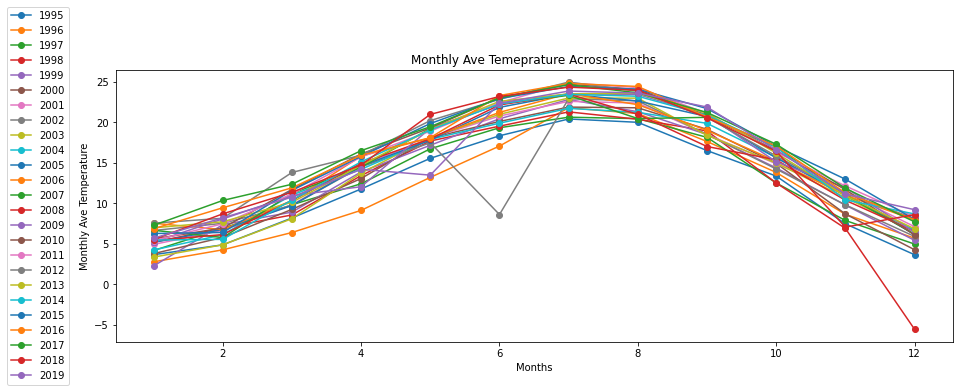

In [17]:
# Analyze first the original series 
# What is the trend? What months, on average is high?
# What to expect when we extract the components?
plt.figure(figsize=(15, 5))
for each in decompose_sample['Year'].unique():
    plt.plot(decompose_sample[decompose_sample['Year'] == each]['Month'],
             decompose_sample[decompose_sample['Year'] == each]['AvgTemperature'], marker='o', label=each)
    
    plt.legend()
    plt.xlabel('Months')
    plt.ylabel('Monthly Ave Temperature')
    plt.title('Monthly Ave Temeprature Across Months')
    
    plt.legend(bbox_to_anchor =(-0.05, 1.25))

    #there are trends in the months 

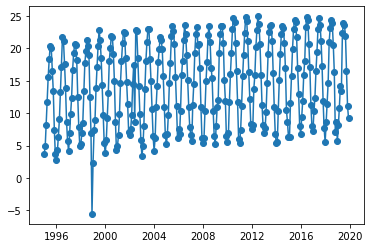

In [18]:
plt.plot(decompose_sample['AvgTemperature'], marker='o')

The decomposition technique used is additive which states that the series can be created by aggregating the estimated componantes together.

In [19]:
result = seasonal_decompose(decompose_sample['AvgTemperature'], model='additive')

Using the additive model to extract trend and seasonality, the first plot shows that there is an increasing trend of average temperatures throughout the years while the second plot shows that there is a seasonality 

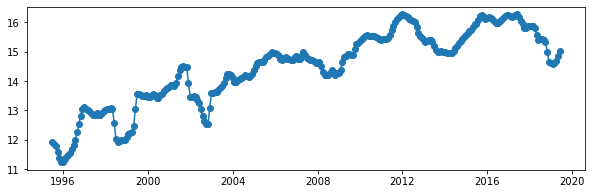

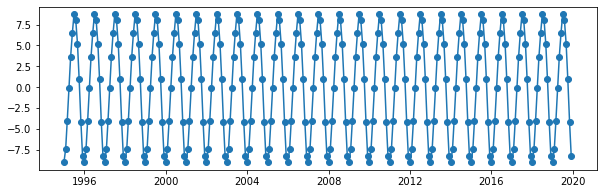

In [20]:
# python does sliding moving avaerage and regression  to extract the trend or seasonality
plt.figure(figsize=(10,3))
# Extracted long term trajectory of your series
plt.plot(result.trend, marker='o') 


plt.figure(figsize=(10,3))
# Extracted seasonality
plt.plot(result.seasonal, marker='o')

# Monthly Expected Temperature

For seasonality, we can see that there are months that are generally colder globally like January and December and the hotter months such as the months of June, July and August

<BarContainer object of 6 artists>

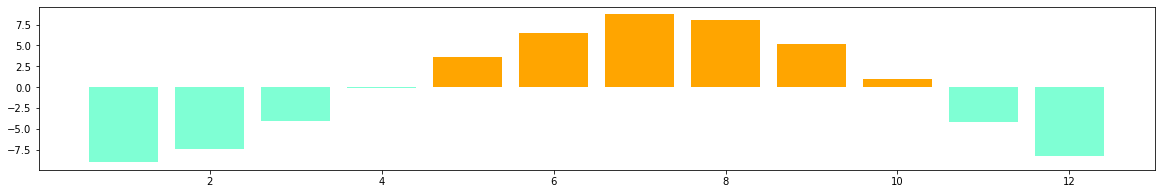

In [21]:
seasonality_value = result.seasonal.reset_index()

seasonality_value['Month'] = seasonality_value['Date'].dt.month
seasonality_value = seasonality_value[['seasonal', 'Month']].drop_duplicates()
plt.figure(figsize=(20,3))

plt.bar(seasonality_value[seasonality_value['seasonal'] > 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] > 0]['seasonal'], color = 'orange')


plt.bar(seasonality_value[seasonality_value['seasonal'] <= 0]['Month'],
        seasonality_value[seasonality_value['seasonal'] <= 0]['seasonal'], color = 'aquamarine')


In numerical terms, as we are using the additive model we can see that january is -9.03 celsius lower than average, and so on

In [22]:
seasonality_value[['seasonal', 'Month']]

,seasonal,Month
0,-9.032508,1
1,-7.422122,2
2,-4.088134,3
3,-0.097102,4
4,3.617031,5
5,6.485884,6
6,8.750894,7
7,8.033184,8
8,5.192594,9
9,0.941796,10


# Monthly Temperature Through The Years Per Country

This function is used for analyzing trend and seasonality of each country. Users must enter the name of the country in the parameter of the function.

In [23]:
def country_analysis(countryDest):    
    per_country = df.loc[df['Country'] == countryDest]
    per_country = per_country.groupby(pd.Grouper(key='Date', freq='MS'))['AvgTemperature'].mean().reset_index()
    per_country = per_country.set_index(pd.to_datetime(per_country['Date'])).dropna()
    per_country.sort_index(inplace=True)


    per_country['Year'] = per_country['Date'].dt.year
    per_country['Month'] = per_country['Date'].dt.month


    plt.figure(figsize=(15, 5))
    for each in per_country['Year'].unique():
        plt.plot(per_country[per_country['Year'] == each]['Month'],
                 per_country[per_country['Year'] == each]['AvgTemperature'], marker='o', label=each)

        plt.legend()
        plt.xlabel('Months')
        plt.ylabel('Monthly Ave Temperature')
        plt.title('Monthly Ave Temeprature Across Months')
        plt.suptitle(countryDest)
        plt.legend(bbox_to_anchor =(-0.05, 1.25))



    country = seasonal_decompose(per_country['AvgTemperature'], model='additive')
    plt.figure(figsize=(10,3))

    # python does sliding moving avaerage and regression  to extract the trend or seasonality

    plt.figure(figsize=(10,3))
    # Extracted long term trajectory of your series
    plt.plot(country.trend, marker='o') 


    plt.figure(figsize=(10,3))
    # Extracted seasonality
    plt.plot(country.seasonal, marker='o')

    plt.legend(bbox_to_anchor =(-0.05, 1.25))


    seasonality_country = country.seasonal.reset_index()

    seasonality_country['Month'] = seasonality_country['Date'].dt.month
    seasonality_country = seasonality_country[['seasonal', 'Month']].drop_duplicates()
    plt.figure(figsize=(20,3))

    plt.bar(seasonality_country[seasonality_country['seasonal'] > 0]['Month'],
            seasonality_country[seasonality_country['seasonal'] > 0]['seasonal'], color = 'orange')


    plt.bar(seasonality_country[seasonality_country['seasonal'] <= 0]['Month'],
            seasonality_country[seasonality_country['seasonal'] <= 0]['seasonal'], color = 'aquamarine')



    seasonality_country[['seasonal', 'Month']]
 

No handles with labels found to put in legend.


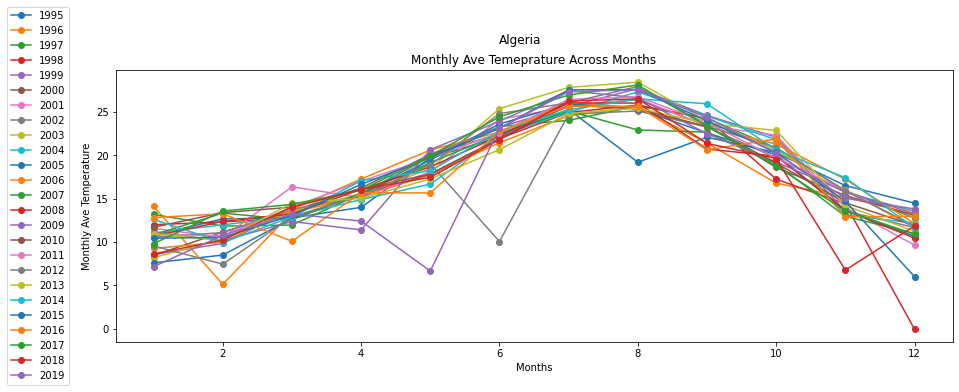

<Figure size 720x216 with 0 Axes>

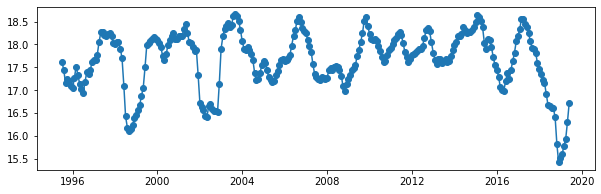

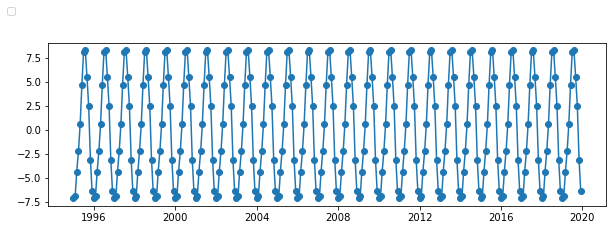

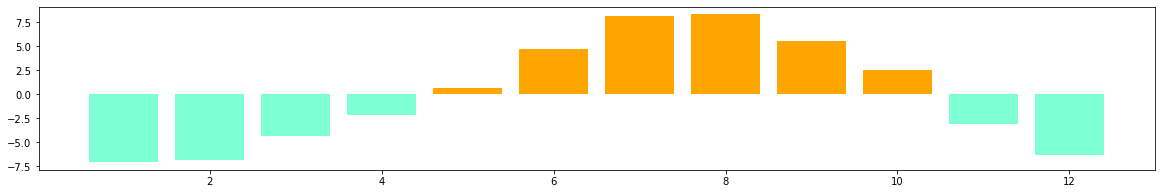

In [24]:
country_analysis("Algeria")

# Correlation of Temperature Increase to Number of Typhoons 

For this part, we try to prove whether or not the correlation exists between typhoon count and ave. temp, we formulated a null and alternative hypothesis. The null hypothesis states that if the p value is greater than 0.05 then there is no correlation between the two variables while if the p value is less than 0.05 then the alternative hypothesis is accepted which means there is a correlation.

Data Dictionary

|Variable |	Definition	| Keys |
|---------|-------------|-------|
|Name	|Name of the Typhoon|	Name|
|*	|Strength of Typhoon|	Symbol|
|Date	|Period of Storm Formation	|Days, Months, Years|


## Typhoon Data Set
Typhoon data was gathered through the IBTRACS website -> http://ibtracs.unca.edu/index.php?name=browse-year-basin

The dataset was extracted in different webpages per year thus, the format of the dataframe contains the column header of the Year and then list of typhoons found in that year. the extraction of data started in the second row since the first row is just a header containing the names of basins for storms.

In [25]:
data = {}
typhoon_df = pd.DataFrame(data)
table = []
for i in range(1995, 2021):
    #Load webpages containing table of typhoon list per year 
    URL="http://ibtracs.unca.edu/index.php?name=YearBasin-"+str(i)
    
    #Getting the information from the entire webpage
    page=requests.get(URL)
    
    #BeautifulSoup is used to parse the page content loaded via the request method
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Get main content <div>
    typhoon_content=soup.find(id='content')
    
    #Get all <table> elements
    typhoon_tables=typhoon_content.find_all('table')
    
    #Get only the second table since it contains the typhoon information
    typhoon_list = typhoon_tables[1]

    extracted_typhoon_names = []
    typhoon_add = ""
    for index in range(2, len(typhoon_list.contents)): #for loop to loop through all typhoons in specific year
        if ((index % 2) == 1) & (index != 1): 
            info_row =typhoon_list.contents[index].text.strip().split()
            for x in range(0,len(info_row)): #for loop to find typhoons in each row
                typhoon_raw_info = info_row[x]
                if typhoon_raw_info.isupper() & (typhoon_raw_info != "NOT_NAMED"):#Drop Not_Named Typhoons 
                    typhoon_add = typhoon_raw_info
                    extracted_typhoon_names.append(typhoon_add)
    
    ind = [x for x in range(0, len(extracted_typhoon_names))]
    typhoon_df[i] = pd.Series(extracted_typhoon_names, index = ind)
                

In [26]:
#List of the typhoons segregated per year in columns
typhoon_df

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,ALLISON,ARTHUR,ANDRES,ALEX,ARLENE,AL04,ALLISON,ARTHUR,ANA,ALEX,...,ARLENE,ALBERTO,ANDREA,ARTHUR,ANA,ALEX,ARLENE,ALBERTO,ANDREA,ARTHUR
1,VANIA,AGNIELLE:DARYL,HANNAH,AGATHA,ADRIAN,ALETTA,ADOLPH,ALMA,ANDRES,AGATHA,...,ADRIAN,ALETTA,ALVIN,AMANDA,ANDRES,PALI,ADRIAN,BOLAVEN,ALVIN,AL06
2,BARRY,BARRY,AL05,AL02,AL04,DAMREY,AL02,TAPAH,YANYAN,ABAIMBA,...,AL05,AL04,SONAMU,LINGLING,MEKKHALA,AL05,MAARUTHA,DAHLIA,FANI,VONGFONG
3,ADOLPH,BERTHA,LINDSAY,LUSI,BEATRIZ,ILSA,BARBARA,TRINA,AL03,HETA,...,TASHA,ALENGA,MAHASEN:VIYARU,ALESSIA,ASHOBAA,ROANU,ABELA,FEHI,LIUA,AMPHAN
4,ALBERTINE,EMMA,CYRIL,BONNIE,IRIS,IRIS,WINSOME,BERTHA,ABAIMBA,BONNIE,...,BRET,BERYL,ANAIS,AL03,ADJALI,ANNABELLE,ALFRED,BERYL,BARRY,BELNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,ANGELA,PIPER,AL05,FAITH,AL06,PAUL,VAMEI,HAISHEN,CRAIG,MERBOK,...,AL04,GAEMI,TORAJI,KAMMURI,ATSANI,MEGI,RAMON,ROSA,OLGA,MANGGA
78,ZACK,AL02,BING,GIL,NaN,KAEMI,NaN,PONGSONA,NICHOLAS,NANMADOL,...,WASHI,MALIKSI,PRISCILLA,TRUDY,MALIA,TINA,GUCHOL,LEEPI,AL01,PAULETTE
79,BRIAN,AL04,AL06,AL04,NaN,INNOCENTE,NaN,NaN,KOPPU,TALAS,...,NaN,PRAPIROON,MAN-YI,PHANFONE,ETAU,CHABA,SELMA,WALAKA,LINGLING,MARIE
80,COLLEEN,JENNA,KELI,NaN,NaN,ROSA,NaN,NaN,INIGO,NORU,...,NaN,MARIA,RAYMOND,VANCE,VAMCO,SONGDA,TALIM,RUMBIA,KENNETH,LINFA


## Transforming the Names of Typhoons Per Year into Count

Since we only needed the total number of typhoons, the count function was used to generate a list containing the total no. of typhoons per year

In [27]:
#how many items in column - y axis 
num_typhoons = []
for i in range(1995, 2020):
    num_typhoons.append(typhoon_df[i].count())

print(num_typhoons)

[82, 82, 82, 80, 78, 82, 78, 79, 82, 81, 82, 81, 80, 82, 82, 75, 79, 82, 82, 82, 82, 82, 82, 82, 82]


Generating a list of years from the range of 1995 to 2019

In [28]:
years = [x for x in range(1995, 2020)]
print(years)

[1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


## Visual representation of Typhoon count through the Years

From this visualization, you can see that the number typhoons is often constant throughout the years with a ceiling value of 82.

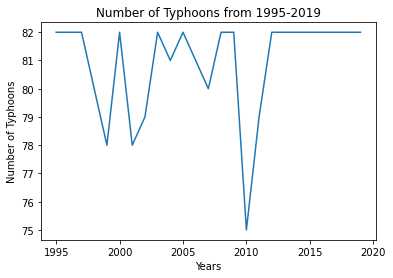

In [29]:
plt.plot(years, num_typhoons)
plt.xlabel('Years')
plt.ylabel('Number of Typhoons')
plt.title('Number of Typhoons from 1995-2019')
plt.show()

## Create a Duplicate Data Frame of the Dataset from Global Average Temperature of Countries 

The dataset from the previous part is used to create a new data frame

In [30]:
temp = df.copy()
temp

,Region,Country,City,Month,Day,Year,AvgTemperature,dateInt,Date,Weekday Index,Weekday Name,IsWeekday
0,Africa,Algeria,Algiers,1,1,1995,17.89,19950101,1995-01-01,6,Sunday,Weekend
1,Africa,Algeria,Algiers,1,2,1995,9.67,19950102,1995-01-02,0,Monday,Weekday
2,Africa,Algeria,Algiers,1,3,1995,9.33,19950103,1995-01-03,1,Tuesday,Weekday
3,Africa,Algeria,Algiers,1,4,1995,8.00,19950104,1995-01-04,2,Wednesday,Weekday
4,Africa,Algeria,Algiers,1,5,1995,8.83,19950105,1995-01-05,3,Thursday,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...
2899401,North America,US,Cheyenne,12,27,2019,-3.83,20191227,2019-12-27,4,Friday,Weekday
2899402,North America,US,Cheyenne,12,28,2019,-4.83,20191228,2019-12-28,5,Saturday,Weekend
2899403,North America,US,Cheyenne,12,29,2019,-8.06,20191229,2019-12-29,6,Sunday,Weekend
2899404,North America,US,Cheyenne,12,30,2019,-8.00,20191230,2019-12-30,0,Monday,Weekday


Data is grouped by Year and its corresponding Average Temperature and then extracted into a list containing ONLY the Average Temperature per year.

In [31]:
#Extracting Year and Average from the dataframe
ave_temp = temp.groupby('Year')['AvgTemperature'].mean().reset_index()

list(ave_temp['AvgTemperature'])
temp_list = list(ave_temp['AvgTemperature'])

## Merge Year, Number, and Average Temperature list into a single Data Frame

A single data frame containing ONLY the Year, Number of Typhoons and Average Temperature that corresponds to the year is created using the three lists(year, number of typhoons, and average temperature) made previously

In [32]:
temp_storm = pd.DataFrame({})
years = np.array(years)
nt = np.array(num_typhoons)
atnew = ave_temp['AvgTemperature'].tolist()
at = np.array(atnew)

temp_storm['Year'] = years.tolist()
temp_storm['Number of Typhoons'] = nt.tolist()
temp_storm['Average Temperature'] = at.tolist()

temp_storm

,Year,Number of Typhoons,Average Temperature
0,1995,82,12.013553
1,1996,82,11.805753
2,1997,82,12.848508
3,1998,80,12.154598
4,1999,78,13.533397
5,2000,82,13.405024
6,2001,78,14.335776
7,2002,79,13.246914
8,2003,82,13.848461
9,2004,81,14.132602


### Data Type and Structure

The shape function shows that the data frame has 25 rows and 3 columns

In [33]:
temp_storm.shape

(25, 3)

The info function shows the two data types integer and float in the data frame

In [34]:
temp_storm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 25 non-null     int64  
 1   Number of Typhoons   25 non-null     int64  
 2   Average Temperature  25 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 728.0 bytes


In [35]:
temp_storm.describe()

,Year,Number of Typhoons,Average Temperature
count,25.000000,25.000000,25.000000
mean,2007.000000,80.920000,14.465962
std,7.359801,1.823915,1.318046
min,1995.000000,75.000000,11.805753
25%,2001.000000,80.000000,13.533397
50%,2007.000000,82.000000,14.881042
75%,2013.000000,82.000000,15.483933
max,2019.000000,82.000000,16.292057


## Plotting the Average Temperature in Histogram

This histogram was only created for comparison to see if the shape is similar to the plot of z-scores of Average Temperature

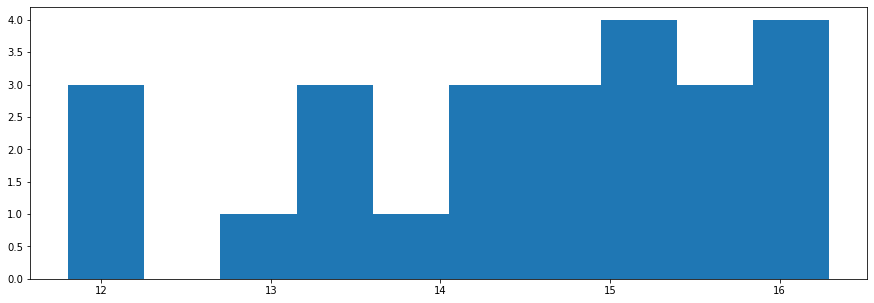

In [36]:
plt.figure(figsize=(15,5))
plt.hist(temp_storm['Average Temperature']);

In [37]:
#create a pseudo-column for zscore average temperature
temp_storm['zscore_avg_temp'] = zscore(temp_storm['Average Temperature'])

In [38]:
temp_storm['zscore_avg_temp'].describe()

count    2.500000e+01
mean     8.859580e-16
std      1.020621e+00
min     -2.059917e+00
25%     -7.221263e-01
50%      3.214151e-01
75%      7.882597e-01
max      1.414026e+00
Name: zscore_avg_temp, dtype: float64

## Plotting the Z-Scores of Average Temperature and Number of Typhoons in Histogram

### Histogram of Average Temperature Z-Scores

From this we can see that shape of the histogram of Avg. Temperature and Z-scores of Avg. Temperature are the same. Only the values in the x-axis are different since the x-axis of the z-scores contains smaller values. The assumption on z-scores proves true in this case.

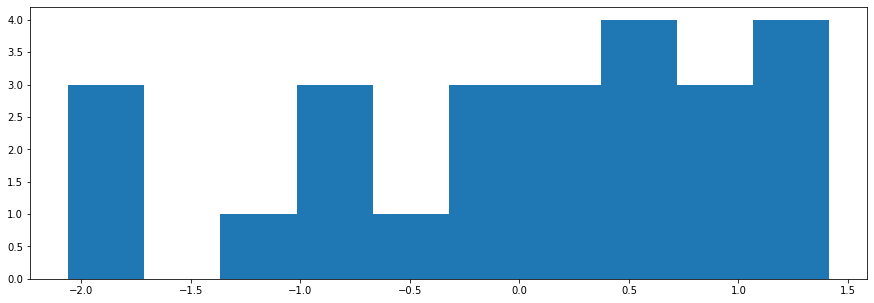

In [39]:
plt.figure(figsize=(15,5))
plt.hist(temp_storm['zscore_avg_temp']);

### Histogram of Number of Typhoons Z-Scores

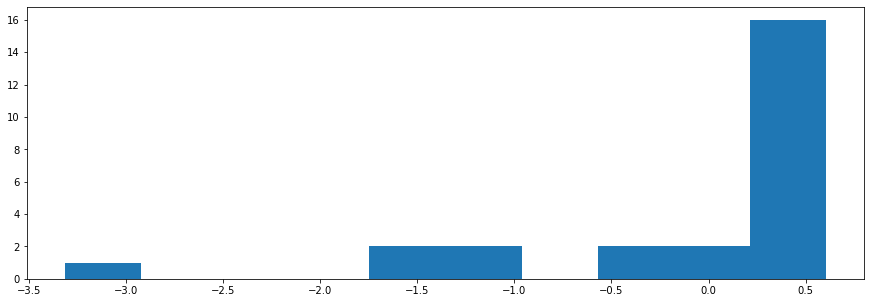

In [40]:
temp_storm['zscore_num_typhoons'] = zscore(temp_storm['Number of Typhoons'])
plt.figure(figsize=(15,5))
plt.hist(temp_storm['zscore_num_typhoons']);

## Data of Average and Number of Typhoons is converted to Z-Scores

The data is converted into z-scores since avg. temperature and number typhoons uses different scaling thus, without z-scores it would be hard to make comparison 

In [41]:
z_scores = zscore(temp_storm['Average Temperature']) 

# Get their absolute values for easy filtering
abs_temp_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_temp = (abs_temp_z_scores < 4) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_temp_z_scores >= 3)

In [42]:
z_scores = zscore(temp_storm['Number of Typhoons']) 

# Get their absolute values for easy filtering
abs_ty_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_typhoons = (abs_ty_z_scores < 4) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_ty_z_scores >= 3)

In [43]:
filtered_data = temp_storm[filtered_typhoons & filtered_temp]

## Pearson Correlation for Average Temperature and Number of Typhoons per year

Pearson correlation was done in order to show degree of correlation. From the visual representation of Pearson Correlation, you can see that the points are plotted randomly and far from each other thus implying no strong correlation neither increasing or decreasing.

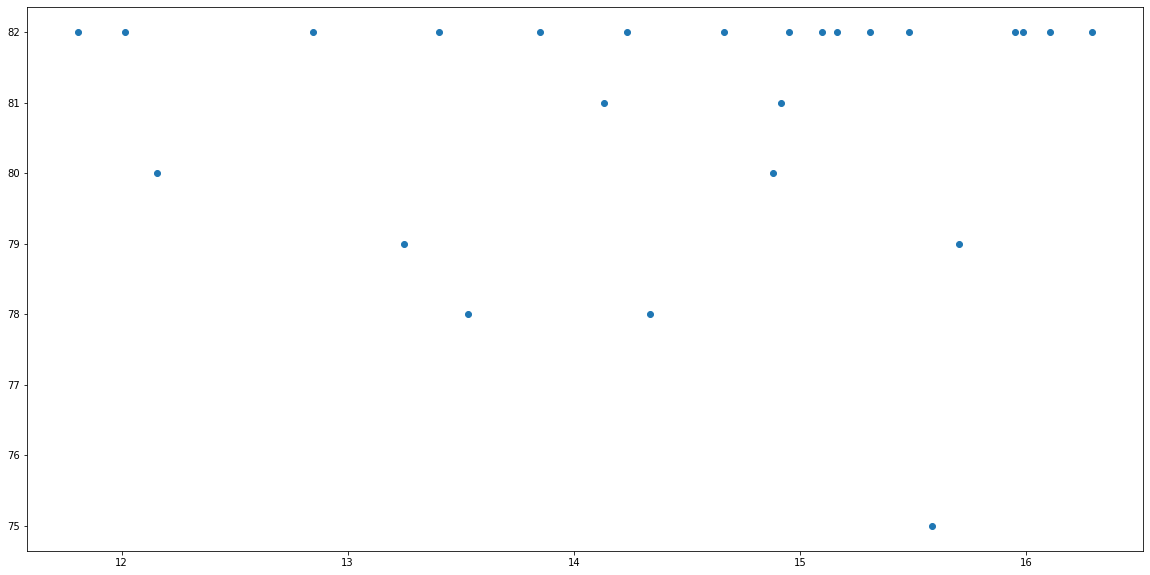

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(filtered_data['Average Temperature'],filtered_data['Number of Typhoons']);

## Pearson Correlation Coefficient

If the p value > 0.05 then null hypothesis is true while vnull hypothesis is rejected if the p value < 0.05. Since p-value is greater than 0.5 this shows that there is really no correlation between number of typhoons per year to the increase of average temperature.

In [45]:
pearson_coef, p_value = stats.pearsonr(filtered_data['Average Temperature'],filtered_data['Number of Typhoons'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.0009935470846313063  with a P-value of P = 0.9962392728617355


# An Analysis of the Relationship Between a Country's Distance From the Equator and its Average Temperature Per Year

Data Dictionary

|Variable|	Definition|	Dtypes|
|---------|---------------------|-------|
Country|	Country's name	|String
Year	|Year taken from data|	Integer
AvgTemperature|	Temperature of the country in Celsius	|Float
Latitude	|Country's Alpha-2 Code |	String
Longitude	|Latitude in degrees	|Float
Name	|Longitude in degrees|	Float
Country	|Country's name	| String|

To get the ideal dataset for this analysis, we'll use only the Country, Year, and Average Temperature from the previous dataset

In [46]:
df2 = df.copy()
df2 = df[['Country', 'Year', 'AvgTemperature']]
df2 = df2.groupby(['Country', 'Year'], as_index=False).agg(AvgTemperature=('AvgTemperature', np.mean))
df2

,Country,Year,AvgTemperature
0,Albania,1995,-72.780000
1,Albania,1996,-72.780000
2,Albania,1997,-66.795781
3,Albania,1998,-43.443616
4,Albania,1999,-2.947014
...,...,...,...
2518,Yugoslavia,2015,12.919208
2519,Yugoslavia,2016,11.855847
2520,Yugoslavia,2017,13.083973
2521,Yugoslavia,2018,12.854849


In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         2523 non-null   object 
 1   Year            2523 non-null   int64  
 2   AvgTemperature  2523 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.3+ KB


## Data Set

For getting the distance of each country from the equator, we use the dataset from [Dataset Publishing Language - countries.csv
](https://github.com/google/dspl/blob/master/samples/google/canonical/countries.csv) on GitHub that includes information we need on this analysis which is the latitude of each country.

In [48]:
latitude_df = pd.read_csv('./countries.csv')
latitude_df

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


In [49]:
latitude_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    244 non-null    object 
 1   latitude   244 non-null    float64
 2   longitude  244 non-null    float64
 3   name       245 non-null    object 
dtypes: float64(2), object(2)
memory usage: 7.8+ KB


## Swap Position of 'name' and 'country' column

We'll swap names and columns of `name` and `country` for better readability and keep only columns `country` and `latitude` since those are the only data we need.

In [50]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

latitude_df = swap_columns(latitude_df, 'name', 'country')

In [51]:
latitude_df = latitude_df[['name', 'latitude']]
latitude_df = latitude_df.rename(columns={'name': 'Country', 'latitude': 'Latitude'})
latitude_df

,Country,Latitude
0,Andorra,42.546245
1,United Arab Emirates,23.424076
2,Afghanistan,33.939110
3,Antigua and Barbuda,17.060816
4,Anguilla,18.220554
...,...,...
240,Yemen,15.552727
241,Mayotte,-12.827500
242,South Africa,-30.559482
243,Zambia,-13.133897


## Merging Data Frames

Next thing to do is to merge both dataframes to have an ideal dataframe for our analysis. We will do an `inner` merge so we only have data that are available for both dataframes.

In [52]:
rel_df = pd.merge(df2, latitude_df, how='inner', on='Country')
rel_df

,Country,Year,AvgTemperature,Latitude
0,Albania,1995,-72.780000,41.153332
1,Albania,1996,-72.780000,41.153332
2,Albania,1997,-66.795781,41.153332
3,Albania,1998,-43.443616,41.153332
4,Albania,1999,-2.947014,41.153332
...,...,...,...,...
2318,Vietnam,2015,23.753087,14.058324
2319,Vietnam,2016,24.024481,14.058324
2320,Vietnam,2017,24.546411,14.058324
2321,Vietnam,2018,23.559151,14.058324


Some values for Latitude are negative since it is measured north of the equator. Making all negative values positive will allow our plots to look more sensible/readable.

In [53]:
rel_df['Latitude'] = rel_df['Latitude'].abs()

Check if there are any NaN values

In [54]:
rel_df.isnull().sum()

Country           0
Year              0
AvgTemperature    0
Latitude          0
dtype: int64

### Data Types

The types of data found in the data frame are int and float

In [55]:
rel_df.dtypes

Country            object
Year                int64
AvgTemperature    float64
Latitude          float64
dtype: object

In [56]:
rel_copy = rel_df

In [57]:
years = rel_copy['Year'].unique()

## Using Scatter Plot

The code below was used to get the scatter plot to show the relationship between the countries' distance from the equator and its average temperature per year.

In [1]:
for i in years:
    a = rel_copy[(rel_copy.Year == i)]
    x = a['Latitude']
    y = a['AvgTemperature']
    
    col_lat = a["Latitude"]
    max_lat = col_lat.max()
    
    col_temp = a["AvgTemperature"]
    max_temp = col_temp.max()
    
    sc_title = "Year "+str(i)
    
    plt.scatter(x, y, s=5, c=x, cmap='tab20')
    plt.gca().update(dict(title=sc_title))
    
    plt.xlabel("Distance from the equator")
    plt.ylabel("Average Yearly Temperature")
    
    plt.xlim(0, max_lat + 10)
    plt.ylim(0, max_temp + 10)
    
# exports plot to make gif
    #file = "output" + str(i) + ".jpg"
    #plt.savefig(file)

# shows the different scatter plots individually
    #plt.pause(1)
    #clear_output()
#plt.show()

NameError: name 'years' is not defined

This gif below shows the different scatter plots created from the data. The different colors represent the different degrees of temperature a country can have.

<img src="gif.gif" width="750" align="center">

The data above shows the relationship between each country's distance from the equator and their average temperature per year. As seen in the gif above, a country closer to the equator has a higher averaged yearly temperature and those farther from the equator have a lower averaged yearly temperature. We can also see that the avereged yearly temperature of each country does not progress or regress contiuously. This may be the result of multiple factors affecting a country's temperature.

# Correlation of Average Temperature Increase per Country to the depletion of Ozone Layer


Data Dictionary

|Variable|	Definition|	Dtype|
|---------|---------------------|-------|
|Country|	Country's name|	String|
|Year|	Year taken from data	|Integer|
|Mean Temp|	Temperature of the country in Celsius|	Float|
|Latitude|	Country's Alpha-2 Code|	String|
|Longitude|	Latitude in degrees|	Float|
|Country Code|	Longitude in degrees|	Float|




## Data Set

Two datasets are used  in this section, the [countries.csv](https://github.com/google/dspl/blob/master/samples/google/canonical/countries.csv) from github and the [FAOSTAT](https://www.fao.org/faostat/en/#data/ET) that shows yearly change in temp per country by Food and Agriculture Organization of the United Nations. As the two main Ozone Hotspot Layers are in Antarctica and the Arctic, the countries will be divided into 3 equal groups and see if there is a significant difference in yearly mean temp depending whether a country is close to an Ozone Hotspot or not.

In [59]:
df = pd.read_csv('countries.csv')
df2 = pd.read_csv('FAOSTAT_data.csv')

As seen below df has 4 columns showing country, latitude, longitude, and name

In [60]:
df

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


in df2 there are a lot of columns but the only ones needed are Year, Value, and Area

In [61]:
df2

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change,2,Afghanistan,7271,Temperature change,7020,Meteorological year,1961,1961,?C,-0.105,Fc,Calculated data
1,ET,Temperature change,2,Afghanistan,7271,Temperature change,7020,Meteorological year,1962,1962,?C,-0.157,Fc,Calculated data
2,ET,Temperature change,2,Afghanistan,7271,Temperature change,7020,Meteorological year,1963,1963,?C,0.852,Fc,Calculated data
3,ET,Temperature change,2,Afghanistan,7271,Temperature change,7020,Meteorological year,1964,1964,?C,-0.743,Fc,Calculated data
4,ET,Temperature change,2,Afghanistan,7271,Temperature change,7020,Meteorological year,1965,1965,?C,-0.211,Fc,Calculated data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13759,ET,Temperature change,181,Zimbabwe,7271,Temperature change,7020,Meteorological year,2017,2017,?C,0.116,Fc,Calculated data
13760,ET,Temperature change,181,Zimbabwe,7271,Temperature change,7020,Meteorological year,2018,2018,?C,0.405,Fc,Calculated data
13761,ET,Temperature change,181,Zimbabwe,7271,Temperature change,7020,Meteorological year,2019,2019,?C,0.939,Fc,Calculated data
13762,ET,Temperature change,181,Zimbabwe,7271,Temperature change,7020,Meteorological year,2020,2020,?C,0.415,Fc,Calculated data


## Renaming Column Headers

in df and df2, the column headers have been renamed for better readability and to lessen confusion on what the headers mean

In [62]:
df.columns = ['Country Code', 'Latitude', 'Longtitude', 'Country']

In [63]:
df2 = df2[['Area','Year','Value']]
df2.columns = ['Country','Year','Mean Change in Temperature (C°)']
df2

,Country,Year,Mean Change in Temperature (C°)
0,Afghanistan,1961,-0.105
1,Afghanistan,1962,-0.157
2,Afghanistan,1963,0.852
3,Afghanistan,1964,-0.743
4,Afghanistan,1965,-0.211
...,...,...,...
13759,Zimbabwe,2017,0.116
13760,Zimbabwe,2018,0.405
13761,Zimbabwe,2019,0.939
13762,Zimbabwe,2020,0.415


### Data Types

The types of data used in this dataframe are object, int, and float

In [64]:
df2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13764 entries, 0 to 13763
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          13764 non-null  object 
 1   Year                             13764 non-null  int64  
 2   Mean Change in Temperature (C°)  13248 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 322.7+ KB


## Calculate Distance using Haversine Formula

Below is the Haversine formula, it will calculate the distance on a round surface more accurately than just adding and subtracting the longitudes and latitudes of countries. This will be used to get the distance between countries and Antarctica

In [65]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    This function calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

Countries containing a Country Code with NA or a a null value are dropped 

In [66]:
df.at[156,'Country Code']='NA'
df4 = df
df4 = df4.dropna()
df4

,Country Code,Latitude,Longtitude,Country
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


## Renaming of Country Name

Below country names have been renamed so that the name of the countries are matched for both dataframes and information won't accidentally get lost, duplicated or unused

In [67]:
#nc = near_cont
#fc = far_cont

df1 = df2
df1.loc[df1['Country'] == 'Cabo Verde', 'Country'] = 'Cape Verde'
df1.loc[df1['Country'] == "C?te d'Ivoire", 'Country'] = "Côte d'Ivoire"

df1.loc[df1['Country'] == 'United Republic of Tanzania', 'Country'] = 'Tanzania'
df1.loc[df1['Country'] == 'French Guyana', 'Country'] = 'French Guiana'
df1.loc[df1['Country'] == 'Pitcairn', 'Country'] = 'Pitcairn Islands'
df1.loc[df1['Country'] == 'Eswatini', 'Country'] = 'Swaziland'
df1.loc[df1['Country'] == 'Sao Tome and Principe', 'Country'] = 'São Tomé and Príncipe'
df1.loc[df1['Country'] == 'Venezuela (Bolivarian Republic of)', 'Country'] = 'Venezuela'
df1.loc[df1['Country'] == 'Falkland Islands (Malvinas)', 'Country'] = 'Falkland Islands [Islas Malvinas]'
df1.loc[df1['Country'] == 'Saint Helena, Ascension and Tristan da Cunha', 'Country'] = 'Saint Helena'
df1.loc[df1['Country'] == 'Réunion', 'Country'] = 'Réunion'
df1.loc[df1['Country'] == 'Wallis and Futuna Islands', 'Country'] = 'Wallis and Futuna'
df1.loc[df1['Country'] == 'Democratic Republic of the Congo', 'Country'] = 'Congo [DRC]'
df1.loc[df1['Country'] == 'Congo', 'Country'] = 'Congo [Republic]'
df1.loc[df1['Country'] == 'Netherlands Antilles (former)', 'Country'] = 'Netherlands Antilles'
df1.loc[df1['Country'] == 'United States Virgin Islands', 'Country'] = 'U.S. Virgin Islands'
df1.loc[df1['Country'] == 'Brunei Darussalam', 'Country'] = 'Brunei'
df1.loc[df1['Country'] == 'Cocos (Keeling) Islands', 'Country'] = 'Cocos [Keeling] Islands'
df1.loc[df1['Country'] == 'Bolivia (Plurinational State of)', 'Country'] = 'Bolivia'


df1.loc[df1['Country'] == 'Viet Nam', 'Country'] = 'Vietnam'
df1.loc[df1['Country'] == "Democratic People's Republic of Korea", 'Country'] = 'North Korea'
df1.loc[df1['Country'] == 'Republic of Korea', 'Country'] = 'South Korea'
df1.loc[df1['Country'] == 'Republic of Moldova', 'Country'] = 'Moldova'
df1.loc[df1['Country'] == 'Svalbard and Jan Mayen Islands', 'Country'] = 'Svalbard and Jan Mayen'
df1.loc[df1['Country'] == 'China, Macao SAR', 'Country'] = 'Macau'
df1.loc[df1['Country'] == 'Syrian Arab Republic', 'Country'] = 'Syria'
df1.loc[df1['Country'] == 'North Macedonia', 'Country'] = 'Macedonia [FYROM]'
df1.loc[df1['Country'] == 'Russian Federation', 'Country'] = 'Russia'
df1.loc[df1['Country'] == "Lao People's Democratic Republic", 'Country'] = 'Laos'
df1.loc[df1['Country'] == 'Micronesia (Federated States of)', 'Country'] = 'Micronesia'
df1.loc[df1['Country'] == 'Czechoslovakia', 'Country'] = 'Czech Republic'
df1.loc[df1['Country'] == 'Czechia', 'Country'] = 'Czech Republic'
df1.loc[df1['Country'] == 'Türkiye', 'Country'] = 'Turkey'
df1.loc[df1['Country'] == 'Iran (Islamic Republic of)', 'Country'] = 'Iran'
df1.loc[df1['Country'] == 'Myanmar', 'Country'] = 'Myanmar [Burma]'
df1.loc[df1['Country'] == 'China, Hong Kong SAR', 'Country'] = 'Hong Kong'
df1.loc[df1['Country'] == 'China, Taiwan Province of', 'Country'] = 'Taiwan'
df1.loc[df1['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'United Kingdom'
df1.loc[df1['Country'] == 'United States of America', 'Country'] = 'United States'
df1.loc[df1['Country'] == 'Palestine', 'Country'] = 'Palestinian Territories'


df1

,Country,Year,Mean Change in Temperature (C°)
0,Afghanistan,1961,-0.105
1,Afghanistan,1962,-0.157
2,Afghanistan,1963,0.852
3,Afghanistan,1964,-0.743
4,Afghanistan,1965,-0.211
...,...,...,...
13759,Zimbabwe,2017,0.116
13760,Zimbabwe,2018,0.405
13761,Zimbabwe,2019,0.939
13762,Zimbabwe,2020,0.415


## Calculating Distance from each Country to Antartica 

Below the distance from each country and antarctica has been measured in kilometers, the dataframe is arranged from lowest distance to antarctica to highest. Which could then be used to split it into 3 groups. One for countries close to antarctica, one that's close to the opposite which is the arctic, and one that's not near either. 

In [68]:
df4['distance_km'] = df4.apply(lambda x: calculate_distance(-75.250973,-0.071389, x['Latitude'], x['Longtitude']), axis=1)

df4 = df4.sort_values('distance_km')
df4 = df4.reset_index(drop=True)
#81 first far country AQ
df4 = df4[df4.distance_km != 0.0].sort_values('distance_km')
df4 = df4.reset_index(drop=True)
near_antarc = df4.iloc[:80]
near_arc = df4.iloc[158:]
far_both = df4.iloc[80:158]
df4

,Country Code,Latitude,Longtitude,Country,distance_km
0,BV,-54.423199,3.413194,Bouvet Island,2320.844550
1,GS,-54.429579,-36.587909,South Georgia and the South Sandwich Islands,2790.221359
2,FK,-51.796253,-59.523613,Falkland Islands [Islas Malvinas],3654.445192
3,HM,-53.081810,73.504158,Heard Island and McDonald Islands,3922.397516
4,TF,-49.280366,69.348557,French Southern Territories,4191.065095
...,...,...,...,...,...
238,IS,64.963051,-19.020835,Iceland,15649.543373
239,CA,56.130366,-106.346771,Canada,16393.207093
240,GL,71.706936,-42.604303,Greenland,16594.455765
241,RU,61.524010,105.318756,Russia,16892.415270


## Data is Grouped By Year and Yearly Mean 

The new dataframes will be grouped by Years and aggragated by the Yearly Mean Temp of each country in that dataframe, therefore getting the average temp of all countries in that group for a year

In [69]:
near_antarc = pd.merge(near_antarc, df1, how='left', on='Country')
#near_antarc = near_antarc.drop(columns=['Country Code','Latitude','Longtitude'])

near_antarc = near_antarc.groupby(['Year'], as_index = False).agg(Yearly_Mean=('Mean Change in Temperature (C°)', np.mean))
#near_antarc = near_antarc.groupby(['Country','distance_km'], as_index = False).count().sort_values('distance_km')
near_antarc= near_antarc[near_antarc.Year != 0]
near_antarc = near_antarc.reset_index(drop=True)
near_antarc

,Year,Yearly_Mean
0,1961.0,0.054056
1,1962.0,-0.057452
2,1963.0,-0.036417
3,1964.0,-0.135958
4,1965.0,-0.205620
...,...,...
56,2017.0,1.120563
57,2018.0,0.931451
58,2019.0,1.235690
59,2020.0,1.187732


In [70]:
near_arc = pd.merge(near_arc, df1, how='left', on='Country')
near_arc = near_arc.drop(columns=['Country Code','Latitude','Longtitude'])
near_arc = near_arc.groupby(['Year'], as_index = False).agg(Yearly_Mean=('Mean Change in Temperature (C°)', np.mean))
#near_arc = near_arc.groupby(['Country','distance_km'], as_index = False).count().sort_values('distance_km')#agg(Yearly_Mean=('Mean Change in Temperature (C°)', np.mean))
near_arc = near_arc[near_arc.Year != 0]
near_arc = near_arc.reset_index(drop=True)
near_arc

,Year,Yearly_Mean
0,1961.0,0.528415
1,1962.0,-0.145736
2,1963.0,-0.228509
3,1964.0,-0.080057
4,1965.0,-0.360057
...,...,...
56,2017.0,1.478831
57,2018.0,1.770312
58,2019.0,1.767169
59,2020.0,1.948286


In [71]:
far_both = pd.merge(far_both, df1, how='left', on='Country')
far_both = far_both.drop(columns=['Country Code','Latitude','Longtitude'])
#fc.drop([41,120,13,112,59,39,33,56,84], axis=0, inplace=True)

far_both = far_both.groupby(['Year'], as_index = False).agg(Yearly_Mean=('Mean Change in Temperature (C°)', np.mean))
#far_both = far_both.groupby(['Country','distance_km'], as_index = False).count().sort_values('distance_km')#.agg(Yearly_Mean=('Mean Change in Temperature (C°)', np.mean))

#pd.set_option('display.max_rows', None)

far_both = far_both[far_both.Year != 0]
far_both = far_both.reset_index(drop=True)
far_both

,Year,Yearly_Mean
0,1961.0,-0.033843
1,1962.0,0.075700
2,1963.0,0.123800
3,1964.0,-0.048841
4,1965.0,-0.210400
...,...,...
56,2017.0,1.192652
57,2018.0,1.090282
58,2019.0,1.213114
59,2020.0,1.396116


## Line Graph of Mean Temperature Per Group

Below is a line graph of the 3 groups and the mean temperature each group(Countries Near the Antarctic Ozone Hotspot, Countries Far From Both, Countries Near the Arctic Ozone Hotspot) has per year

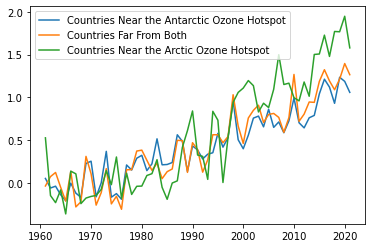

In [72]:
plt.plot(near_antarc.Year, near_antarc.Yearly_Mean, label = "Countries Near the Antarctic Ozone Hotspot")
plt.plot(far_both.Year, far_both.Yearly_Mean, label = "Countries Far From Both")
plt.plot(near_arc.Year, near_arc.Yearly_Mean, label = "Countries Near the Arctic Ozone Hotspot")
plt.legend()
plt.show()

## Using Oneway Anova

Oneway ANOVA is used to see if there will be a significant difference among the groups, as there are 3 groups that needs comparison. It will be less likely to have type 1 errors in the results compared to using the t test twice or thrice.

In [73]:
f_oneway(near_antarc.Yearly_Mean, far_both.Yearly_Mean, near_arc.Yearly_Mean)

F_onewayResult(statistic=1.1802610767907207, pvalue=0.3095644099964155)

The results show that there is no significant difference among the 3 different groups. As seen in the boxplot where the bodies and their midpoints are all nearly aligned meaning that there is no significant difference

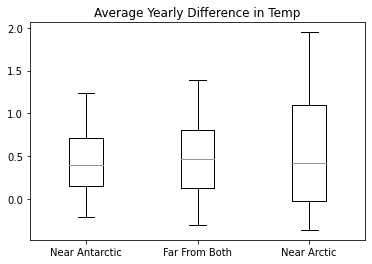

In [74]:
data = [near_antarc.Yearly_Mean, far_both.Yearly_Mean, near_arc.Yearly_Mean]

#plt.boxplot(data)
plt.boxplot(data)
plt.xticks([1, 2, 3], ['Near Antarctic', 'Far From Both', 'Near Arctic'])
plt.title('Average Yearly Difference in Temp')
plt.show()

The results show that there is no significant difference among the 3 different groups. As seen in the boxplot where the bodies and their midpoints are all nearly aligned meaning that there is no significant difference